In [ ]:
! pip install gensim

In [ ]:
! pip install nltk

In [ ]:
! pip install pymystem3

In [ ]:
! pip install bs4

In [1]:
import gensim
import logging
import nltk.data
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
nltk.download('stopwords')
from gensim.models import word2vec
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
morph = MorphAnalyzer()
import re
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—…»«'

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Гриша\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%%time
with open('book_thief.txt', 'r') as f:
    booktext = f.read()
    booktext = booktext.lower()
sents_raw = sent_tokenize(booktext)
sents_n = []
sents_l = []
sw = stopwords.words('russian')
for sent in sents_raw:
    for i in punctuation:
        sent = sent.replace(i, '')
    sents_n.append(re.sub(r'\n', ' ', sent))
for sent in sents_n:
    tokens = (word_tokenize(sent))   # делаю лемматизирование текста 
    for token in tokens:
        annotation = morph.parse(token)
        parse = annotation[0]
        normal_form = parse.normal_form
        sent = sent.replace(token, normal_form)
    sents_l.append(sent)

with open('book_thief_new.txt', 'w', encoding='utf-8') as f: # делаю новый файл для модели
    for i in sents_l:
        f.write(i + '\n')

Wall time: 41.4 s


In [4]:
f = 'book_thief_new.txt'
data = gensim.models.word2vec.LineSentence(f)
%time model_zusak = gensim.models.Word2Vec(data, size=300, window=5, min_count=5, iter=50)
print('end')
model_zusak.init_sims(replace=True)
model_path = "zusak.bin"

print("Saving model...")
%time model_zusak.wv.save_word2vec_format(model_path, binary=True)

2020-06-08 17:40:50,153 : INFO : collecting all words and their counts
2020-06-08 17:40:50,164 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-08 17:40:50,234 : INFO : PROGRESS: at sentence #10000, processed 88723 words, keeping 9965 word types
2020-06-08 17:40:50,244 : INFO : collected 10596 word types from a corpus of 103414 raw words and 11587 sentences
2020-06-08 17:40:50,245 : INFO : Loading a fresh vocabulary
2020-06-08 17:40:50,256 : INFO : effective_min_count=5 retains 2405 unique words (22% of original 10596, drops 8191)
2020-06-08 17:40:50,257 : INFO : effective_min_count=5 leaves 89994 word corpus (87% of original 103414, drops 13420)
2020-06-08 17:40:50,267 : INFO : deleting the raw counts dictionary of 10596 items
2020-06-08 17:40:50,268 : INFO : sample=0.001 downsamples 50 most-common words
2020-06-08 17:40:50,268 : INFO : downsampling leaves estimated 65079 word corpus (72.3% of prior 89994)
2020-06-08 17:40:50,275 : INFO : estimated re

Wall time: 13.8 s
end
Saving model...
Wall time: 18 ms


In [5]:
print('Количество слов в модели: ', len(model_zusak.wv.vocab))

Количество слов в модели:  2405


In [15]:
model_zusak.wv.most_similar('свинья', topn=5) # животное

[('•', 0.6814246773719788),
 ('курить', 0.6594505906105042),
 ('saumensch', 0.6591594815254211),
 ('вправду', 0.6492607593536377),
 ('чемтый', 0.6488664746284485)]

In [14]:
model_zusak.wv.most_similar('смерть', topn=5) # абстрактное понятие

[('добраться', 0.6261947154998779),
 ('потребоваться', 0.5917940735816956),
 ('дошлый', 0.589259922504425),
 ('станция', 0.5751675963401794),
 ('сей', 0.5713270902633667)]

In [9]:
model_zusak.wv.most_similar(positive=['книга', 'магазин'], negative=['человек'], topn=1) # семантическая пропорция

[('карман', 0.6150532960891724)]

In [10]:
model_zusak.wv.doesnt_match('улица война смерть книга небо'.split())

'улица'

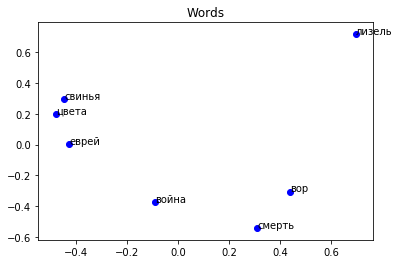

In [11]:
words = ['смерть', 'свинья', 'еврей', 'война', 'лизель', 'вор', 'цвета']
X = model_zusak[words]
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
plt.scatter(coords[:, 0], coords[:, 1], color='blue')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

In [ ]:
old_sent = 'когда люди умирют, небо меняет цвет, мой любимый цвет коричневый'
new_sent = ''
for i in punctuation:  # уберем знаки препинания чтобы не мешались
    old_sent = old_sent.replace(i, '') 
print('Старое предложениее:\n', old_sent)
words = old_sent.split()
sw = stopwords.words('russian')  # будем пропускать стоп-слова, остальные заменять на самое похожее в модели


for w in words:
    annotation = morph.parse(w)
    parse = annotation[0]
    nf = parse.normal_form
    if (nf not in model_zusak.wv.vocab) or (nf in sw):
        most_sim = w
    else:
        most_sim = model_zusak.wv.most_similar(nf, topn=1)
        most_sim = most_sim[0][0]
    new_sent += most_sim + ' '
print('Новое предложение:\n', new_sent)